In [1]:
import pandas as pd
import numpy as np
import unidecode
import geonamescache
import json

data = pd.read_json("./data/headline_countries_cities.json")
data = data.replace({None: np.nan})
data = data.rename(columns=dict(countries="country", cities="city"))
data["headline"].value_counts().sort_values()
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 649
Data columns (total 3 columns):
headline    647 non-null object
country     15 non-null object
city        605 non-null object
dtypes: object(3)
memory usage: 20.2+ KB


In [2]:
gc = geonamescache.GeonamesCache()
with open("./data/city_accent_mapping.json", "r") as file:
    city_accent_mapping = json.loads(file.read())

data["accented_city"] = data["city"].map(city_accent_mapping)
data[data["city"] != data["accented_city"]].head()

,headline,country,city,accented_city
7,Geneve Scientists Battle to Find Cure,NaN,Geneve,Genève
9,Zika Infested Monkeys in Sao Paulo,NaN,Sao Paulo,São Paulo
17,Louisiana Zika cases up to 26,NaN,NaN,NaN
19,Zika infects pregnant woman in Cebu,NaN,NaN,NaN
47,18 new Zika Cases in Bogota,NaN,Bogota,Bogotá


In [3]:
## choose the city with the greatest population
## (if a city was in geonames multiple times)

city_locations = []

for city in data["accented_city"]:
    matches = gc.get_cities_by_name(city)
    if matches:
        matches = [
            {k: v for k, v in list(match.values())[0].items()} for match in matches
        ]
        matches = sorted(matches, key=lambda x: x["population"], reverse=True)
        match = matches[0]
        
        city_locations.append(
            {
                "name": match["name"],
                "latitude": match["latitude"],
                "longitude": match["longitude"],
                "countrycode": match["countrycode"],
                "population": match["population"],
            }
        )
        
city_locations = pd.DataFrame(city_locations).drop_duplicates()

In [4]:
data = pd.merge(
    data, city_locations, left_on="accented_city", right_on="name", how="left"
)
data.head()

,headline,country,city,accented_city,name,latitude,longitude,countrycode,population
0,Zika Outbreak Hits Miami,NaN,Miami,Miami,Miami,25.77427,-80.19366,US,441003.0
1,Could Zika Reach New York City?,NaN,New York City,New York City,New York City,40.71427,-74.00597,US,8175133.0
2,First Case of Zika in Miami Beach,NaN,Miami Beach,Miami Beach,Miami Beach,25.79065,-80.13005,US,92312.0
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife,Recife,Recife,-8.05389,-34.88111,BR,1478098.0
4,Dallas man comes down with case of Zika,NaN,Dallas,Dallas,Dallas,32.78306,-96.80667,US,1300092.0


In [5]:
## since missing values in the country column do not give us much information
## let's remove these countries

data = data.drop(columns=['country'])
pd.options.display.max_colwidth = 100
no_name = data[data["name"].isna()].copy()
no_name.head()

,headline,city,accented_city,name,latitude,longitude,countrycode,population
17,Louisiana Zika cases up to 26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Zika infects pregnant woman in Cebu,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,Spanish Flu Sighted in Antigua,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,Carnival under threat in Rio De Janeiro due to Zika outbreak,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,Zika case reported in Oton,NaN,NaN,NaN,NaN,NaN,NaN,NaN


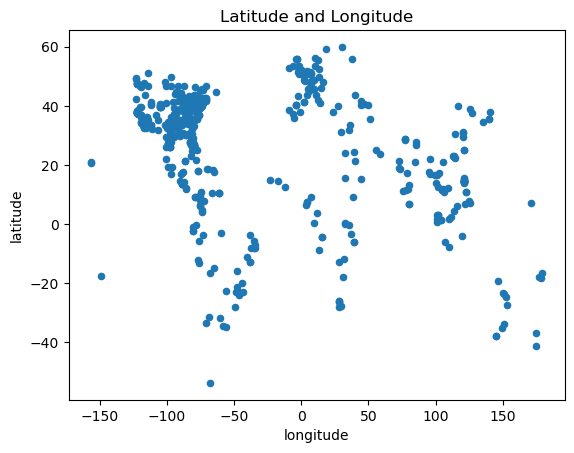

In [6]:
data = data.dropna(subset=["name"])
plt = data.plot.scatter(
    x="longitude", y="latitude", title="Latitude and Longitude"
)

In [7]:
data = data.drop(columns=['name'])
data.to_csv('./data/headlines_locations.csv')